In [1]:
from fastai import *
import networkx as nx
from IPython.display import Image, display

import dis
from collections import defaultdict

import fastai

In [2]:
path = Path(fastai.__file__).parent
print(path)

/anaconda3/lib/python3.7/site-packages/fastai


## Explore the python files in the fastai source tree.  

In [3]:
paths = list(path.rglob("*[!_].py"))  # Get python files recursively, excluding __init__.py
filenames = [str(x).split(str(path)+"/")[1] for x in paths]
sorted(filenames, key=lambda x: len(x))

['core.py',
 'train.py',
 'collab.py',
 'layers.py',
 'metrics.py',
 'version.py',
 'callback.py',
 'datasets.py',
 'text/data.py',
 'torch_core.py',
 'basic_data.py',
 'data_block.py',
 'vision/tta.py',
 'basic_train.py',
 'vision/data.py',
 'text/models.py',
 'tabular/data.py',
 'vision/image.py',
 'imports/core.py',
 'text/learner.py',
 'gen_doc/core.py',
 'callbacks/rnn.py',
 'imports/torch.py',
 'gen_doc/nbdoc.py',
 'callbacks/fp16.py',
 'tabular/models.py',
 'vision/learner.py',
 'text/transform.py',
 'text/qrnn/qrnn.py',
 'callbacks/hooks.py',
 'callbacks/mixup.py',
 'vision/transform.py',
 'callbacks/tracker.py',
 'tabular/transform.py',
 'utils/collect_env.py',
 'vision/models/wrn.py',
 'vision/models/unet.py',
 'gen_doc/docstrings.py',
 'callbacks/lr_finder.py',
 'callbacks/one_cycle.py',
 'callbacks/csv_logger.py',
 'gen_doc/convert2html.py',
 'vision/models/darknet.py',
 'text/qrnn/forget_mult.py',
 'gen_doc/gen_notebooks.py',
 'widgets/image_cleaner.py',
 'callbacks/genera

### Simplify the list of files

We will simplify the remaining analysis and only include the path.name

text/models.py, tabular/models.py get projected to models.py

We are left with only 39 distinct filenames.

In [4]:
len([x.name for x in paths]), len({x.name for x in paths})

(47, 39)

Keep a map from the module name to the filename.  We link back to the shorter filename.

In [5]:
module2fname = {x.split("/")[-1][:-3]:x 
                for x in sorted(filenames, key=lambda x: len(x), reverse=True)}
list(module2fname.items())[:15]

[('general_sched', 'callbacks/general_sched.py'),
 ('darknet', 'vision/models/darknet.py'),
 ('forget_mult', 'text/qrnn/forget_mult.py'),
 ('gen_notebooks', 'gen_doc/gen_notebooks.py'),
 ('image_cleaner', 'widgets/image_cleaner.py'),
 ('csv_logger', 'callbacks/csv_logger.py'),
 ('convert2html', 'gen_doc/convert2html.py'),
 ('lr_finder', 'callbacks/lr_finder.py'),
 ('one_cycle', 'callbacks/one_cycle.py'),
 ('unet', 'vision/models/unet.py'),
 ('docstrings', 'gen_doc/docstrings.py'),
 ('tracker', 'callbacks/tracker.py'),
 ('transform', 'text/transform.py'),
 ('collect_env', 'utils/collect_env.py'),
 ('wrn', 'vision/models/wrn.py')]

In [6]:
def imports_in_file(p:Path) -> Collection[str]:
    "Return the list of imports from python file `p`"
    instructions = dis.get_instructions(open(p).read())
    return [x.argval for x in instructions if ("IMPORT_NAME" in x.opname)]

In [7]:
deps = defaultdict(set)
for x in paths:
    for y in imports_in_file(x):
        deps[x.name.split('.py')[0]].add(y.split('.')[-1])
len(deps), list(deps.items())[:4]

(38,
 [('callback', {'basic_data', 'torch_core'}),
  ('metrics', {'callback', 'torch_core'}),
  ('torch_core', {'core', 'torch'}),
  ('basic_train', {'basic_data', 'callback', 'torch_core'})])

## Let's visualize these dependencies

In [8]:
DG = nx.DiGraph()
keys = set(deps.keys())
for x, y in deps.items():
    for z in y: 
        if z in keys and x != z:
            DG.add_edge(x, z) 

In [9]:
DG.number_of_nodes(), DG.number_of_edges()

(37, 109)

### PyDot visualization to the rescue

In [10]:
#  From https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

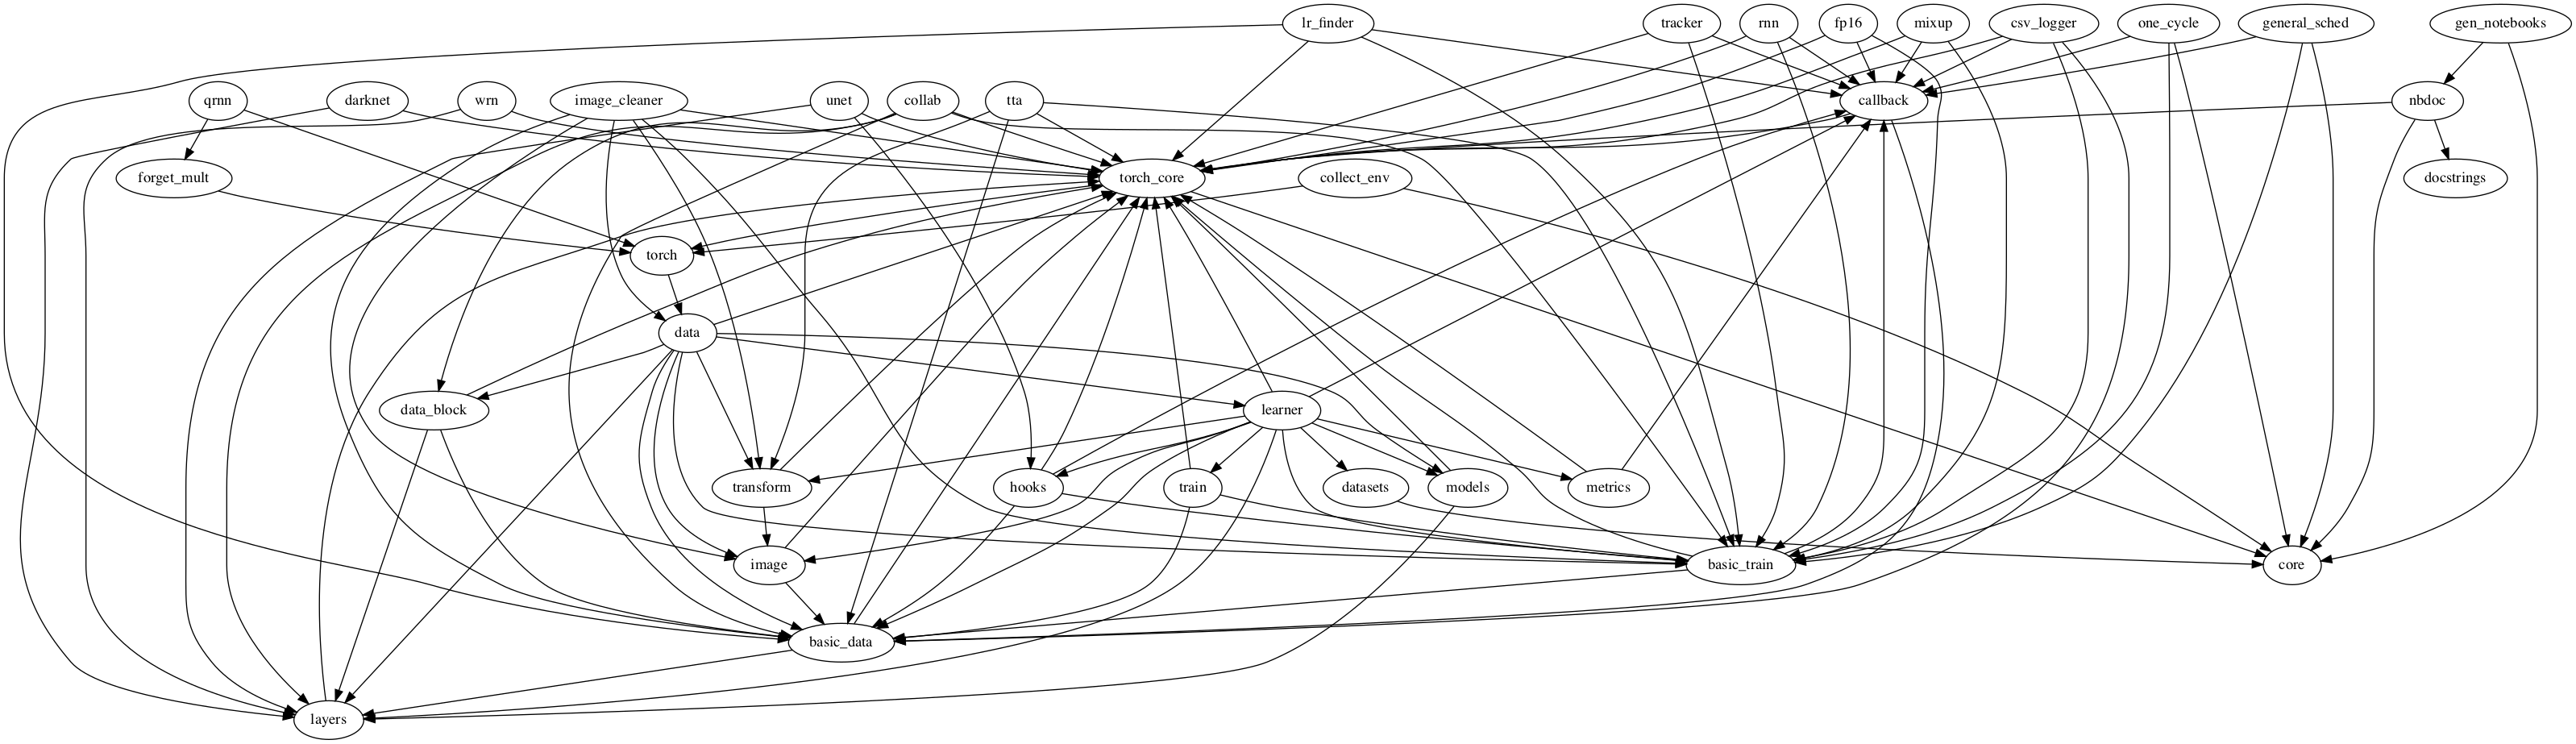

In [11]:
viewPydot(nx.drawing.nx_pydot.to_pydot(DG))

The most important modules to learn are those that are used by others

In [12]:
key_modules = [x for x,y in Counter(y for x,y in DG.edges).most_common() if y>=1]
star_modules = [x for x,y in Counter(y for x,y in DG.edges).most_common() if y>=3]
key_modules, star_modules

(['torch_core',
  'basic_train',
  'basic_data',
  'callback',
  'layers',
  'core',
  'torch',
  'image',
  'transform',
  'data',
  'data_block',
  'models',
  'hooks',
  'learner',
  'datasets',
  'metrics',
  'train',
  'forget_mult',
  'docstrings',
  'nbdoc'],
 ['torch_core',
  'basic_train',
  'basic_data',
  'callback',
  'layers',
  'core',
  'torch',
  'image',
  'transform'])

In [13]:
pdot = nx.drawing.nx_pydot.to_pydot(DG)
for i, node in enumerate(pdot.get_nodes()):
    node_name = str(node).strip(";")
    fname = module2fname[node_name]
    external_url = f"https://github.com/fastai/fastai/blob/master/fastai/{fname}"
    #print(external_url)
    if node_name in star_modules:
        node.set_URL(external_url)
        node.set_shape('egg')
        node.set_style('filled')
        node.set_fillcolor('#66c2a5')
    elif node_name in key_modules:
        node.set_URL(external_url)
        node.set_shape('ellipse')
        node.set_style('filled')
        node.set_fillcolor('#fc8d62')
    else: 
        node.set_URL(external_url)
        node.set_shape('box')
        node.set_style('filled')
        node.set_fillcolor('#8da0cb')

In [14]:
from IPython.display import HTML, SVG, display
no_wrap_div = '<p >{}</p>'
display(HTML(no_wrap_div.format(pdot.create_svg().decode("utf-8"))))

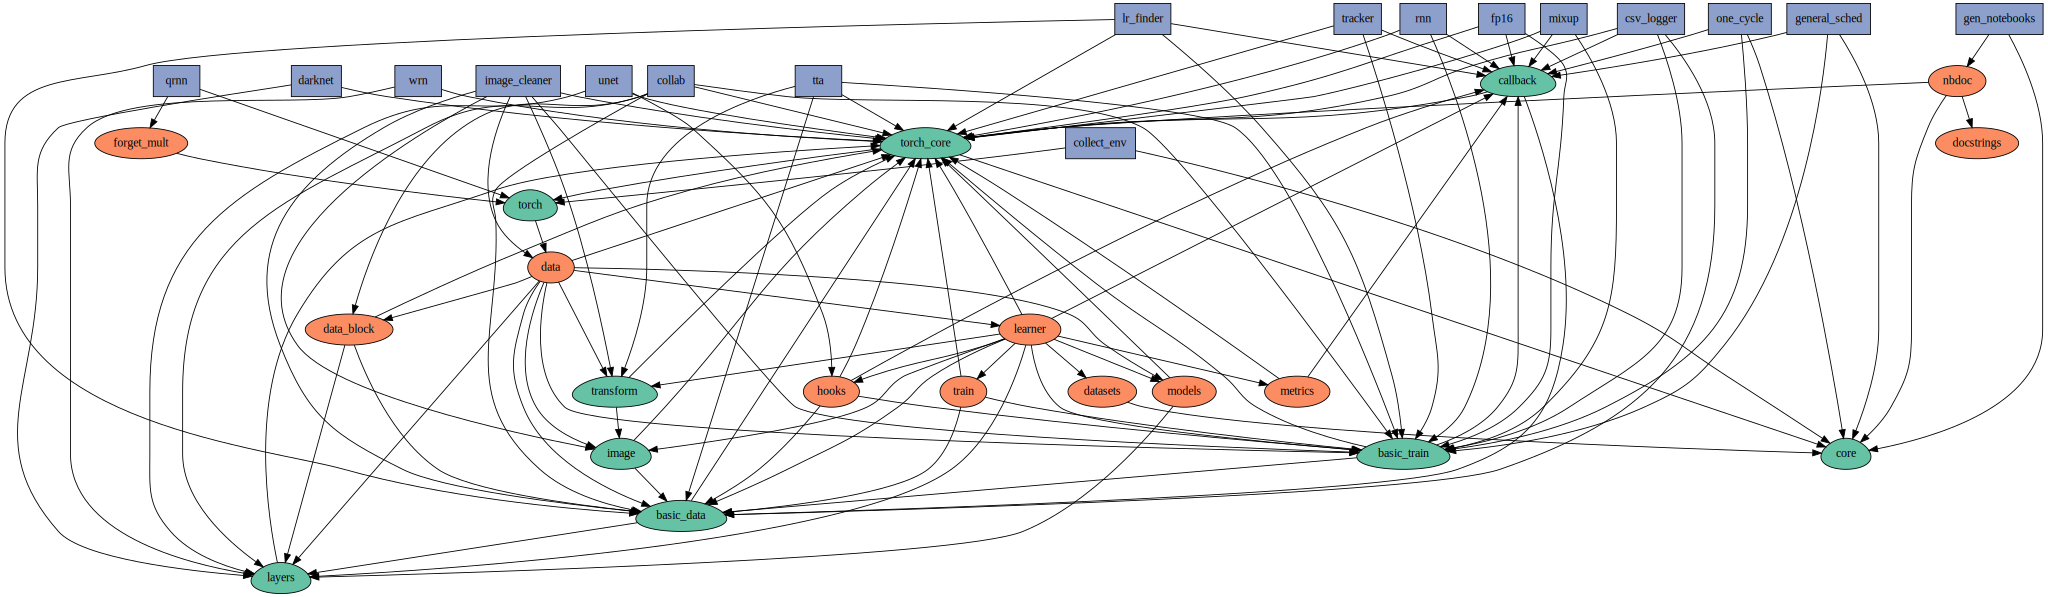

In [16]:
# display large-scale image
display(SVG(pdot.create_svg()))

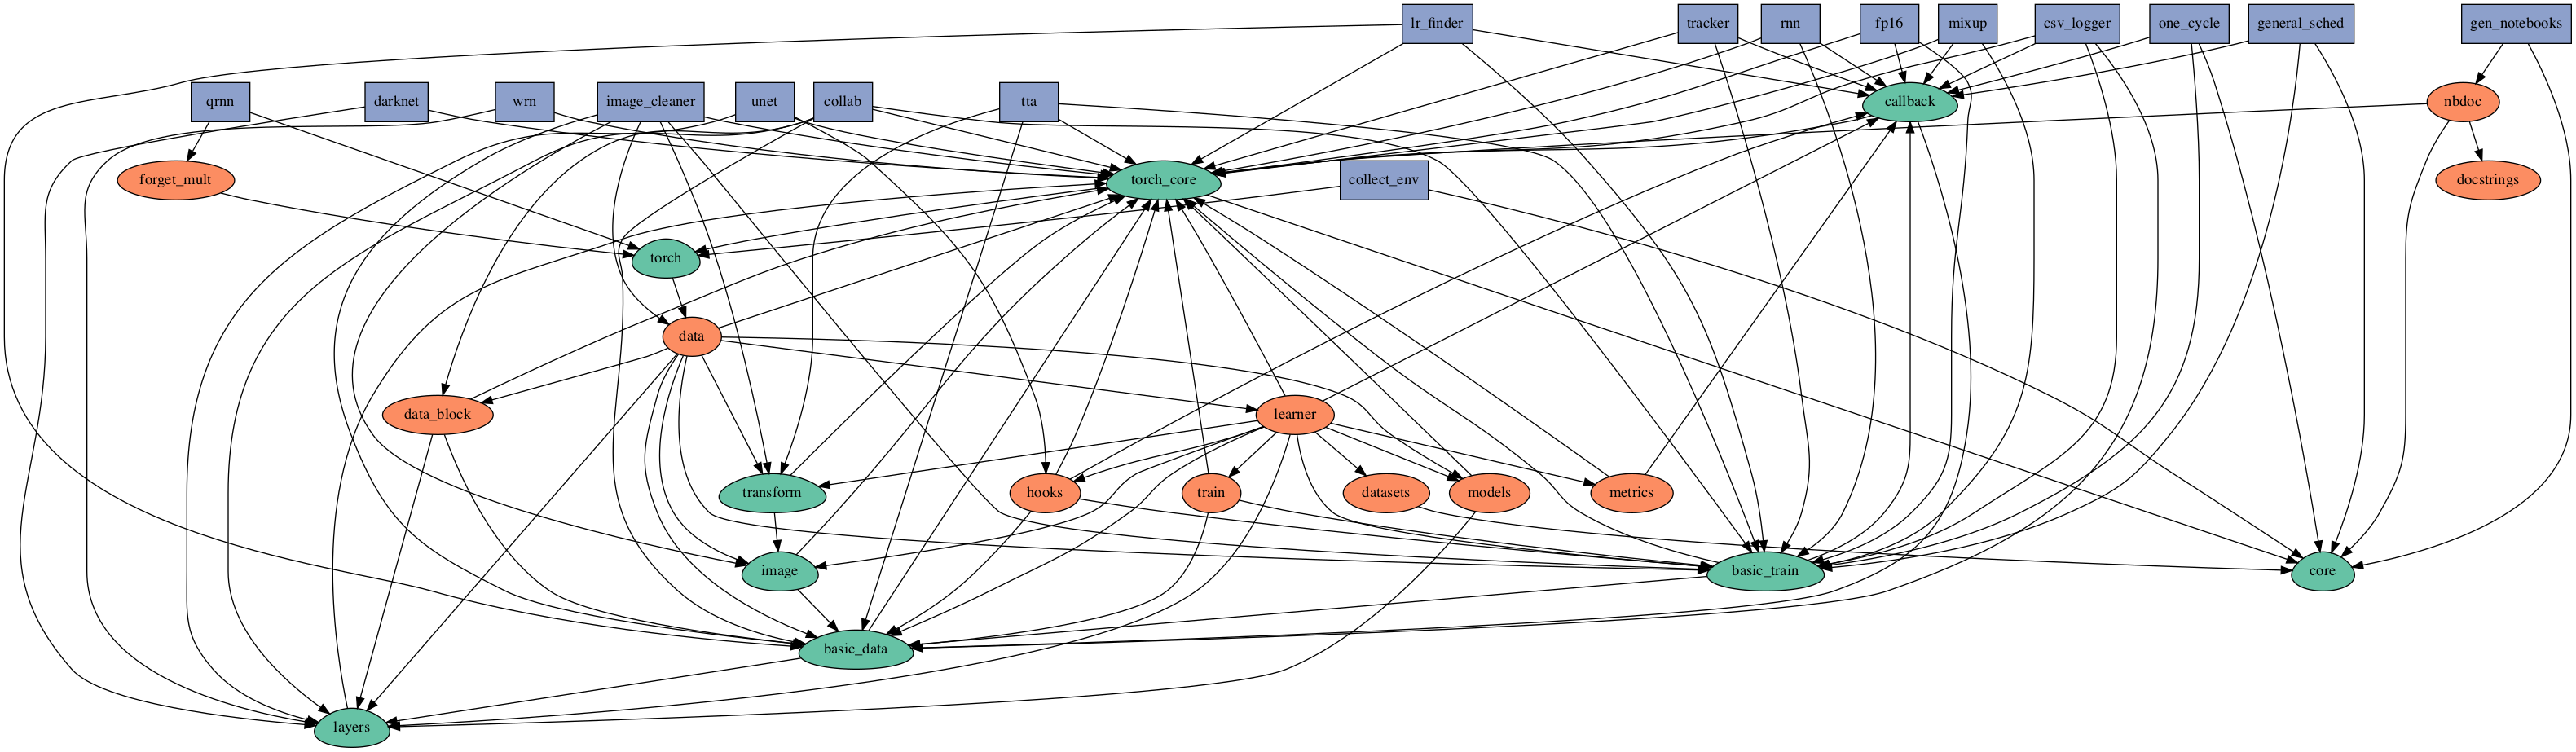

In [17]:
viewPydot(pdot)

In [18]:
pdot.write_png("/tmp/fastai_simplified_deps.png")